## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
import gc
from reproduction import *
import statsmodels.api as sm
from reproduction import *
from data_processing import *

## Data Processing

In [2]:
# Loads data
full_logistics_data_df = load_full_logistics_data()
full_order_data_df = load_full_order_data()
item_df = load_item_data()

In [3]:
action_time_df = compute_action_time(full_logistics_data_df, full_order_data_df)
action_time_df = bin_action_time(action_time_df, bin_size=0.05)

action_time_df.loc[action_time_df['logistics_review_score'] <= 1, 'logistics_review_score'] = 2

action_time_df['day_count'] = action_time_df['shipment_time'].dt.days.apply(np.ceil)

action_time_df = action_time_df[action_time_df['day_count'] <= 8]
action_time_df = action_time_df[action_time_df['day_count'] >= 1]

,order_id,action,timestamp_datetime,sign_time,order_time,logistics_review_score,shipment_time,item_det_info,logistic_company_id,facility_id,merchant_id,action_time,action_time_interval,day_count
0,75208908,ARRIVAL,2017-01-15 16:38:00,2017-01-18 21:14:00,2017-01-14 16:24:00,5.0,4 days 04:50:00,222996:1:157.37,247,176983.0,88,0.240331,0.20,4.0
1,75208908,SENT_SCAN,2017-01-18 21:06:00,2017-01-18 21:14:00,2017-01-14 16:24:00,5.0,4 days 04:50:00,222996:1:157.37,247,176983.0,88,0.998678,0.95,4.0
2,75208908,ARRIVAL,2017-01-18 21:01:00,2017-01-18 21:14:00,2017-01-14 16:24:00,5.0,4 days 04:50:00,222996:1:157.37,247,176983.0,88,0.997851,0.95,4.0
3,75208908,SIGNED,2017-01-18 21:14:00,2017-01-18 21:14:00,2017-01-14 16:24:00,5.0,4 days 04:50:00,222996:1:157.37,247,176983.0,88,1.000000,0.95,4.0
4,75208908,ARRIVAL,2017-01-17 13:33:00,2017-01-18 21:14:00,2017-01-14 16:24:00,5.0,4 days 04:50:00,222996:1:157.37,247,176983.0,88,0.685785,0.65,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50178458,23325254,SIGNED,2017-07-26 10:35:00,2017-07-26 10:35:00,2017-07-23 23:49:00,4.0,2 days 10:46:00,75415:1:20.89,323,NaN,194,1.000000,0.95,2.0
50178475,51308677,SENT_SCAN,2017-07-29 16:44:00,2017-07-29 16:45:00,2017-07-28 16:21:00,5.0,1 days 00:24:00,172335:1:27.11,323,NaN,194,0.999317,0.95,1.0
50178476,51308677,GOT,2017-07-29 11:26:00,2017-07-29 16:45:00,2017-07-28 16:21:00,5.0,1 days 00:24:00,172335:1:27.11,323,NaN,194,0.782104,0.75,1.0
50178477,51308677,CONSIGN,2017-07-29 16:45:00,2017-07-29 16:45:00,2017-07-28 16:21:00,5.0,1 days 00:24:00,172335:1:27.11,323,NaN,194,1.000000,0.95,1.0


In [4]:
def get_item_id(item_det_info):
    return int(item_det_info.split(":")[0])

action_time_df["item_id"] = action_time_df["item_det_info"].apply(get_item_id)
item_df = item_df[item_df["item_id"].isin(action_time_df["item_id"])]
item_df = item_df[["item_id", "merchant_id", "brand_id", "category_id"]]
item_df = item_df.drop_duplicates()

,item_id,merchant_id,brand_id,category_id
1272,258958,275,183,11
4601,109484,305,457,20
29621,202345,275,183,11
37070,267201,247,770,20
37118,6237,247,770,20
...,...,...,...,...
50620533,18167,407,22,54
50623017,207757,185,22,54
50694951,249439,275,183,11
50698141,6160,396,3,53


In [8]:
item_df = item_df[["item_id", "merchant_id", "brand_id", "category_id"]]
item_df = item_df.drop_duplicates()

action_count_df = add_dummy_variables(action_time_df, item_df)
action_time_df = action_time_df[["order_id", "action", "logistics_review_score", "logistic_company_id", "action_time_interval", "day_count", "item_id", "week", "merchant_id"]]

In [9]:
action_count_coefficients = []
action_count_upper_conf_ints = []
action_count_lower_conf_ints = []
bins = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for action_count in range(4, 11):
    bin_coefficients = []
    bin_upper_conf_ints = []
    bin_lower_conf_ints = []
    for bin in bins:
        subsample_df = action_count_df[(action_count_df['total_action_count'] == action_count) & (action_count_df['action_time_interval'] == bin)]
        y = subsample_df['logistics_review_score']
        x = subsample_df[['action_count', 'week', 'day_count', 'facility_count', 'arrive_count', 'depart_count', 'receive_count','scan_count']]
        # x = subsample_df[['action_count', 'merchant_id', 'brand_id', 'category_id', 'logistic_company_id', 'week', 'day_count', 'facility_count', 'arrive_count', 'depart_count', 'receive_count','scan_count']]
        # x = sm.add_constant(x)

        model = sm.OLS(y, x)
        results = model.fit()
        conf_int = results.conf_int(alpha=0.1).loc['action_count'] # alpha=0.1 indicates that we want 90% confidence interval
        bin_upper_conf_ints.append(conf_int[1])
        bin_lower_conf_ints.append(conf_int[0])
        bin_coefficients.append(results.params['action_count'])
    action_count_coefficients.append(bin_coefficients)
    action_count_upper_conf_ints.append(bin_upper_conf_ints)
    action_count_lower_conf_ints.append(bin_lower_conf_ints)

In [10]:
day_count_coefficients = []
day_upper_conf_ints = []
day_lower_conf_ints = []

for day_count in range(2, 9):
    bin_coefficients = []
    bin_upper_conf_ints = []
    bin_lower_conf_ints = []
    for bin in bins:
        subsample_df = action_count_df[(action_count_df['day_count'] == day_count) & (action_count_df['action_time_interval'] == bin)]
        y = subsample_df['logistics_review_score']
        x = subsample_df[['action_count', 'week', 'day_count', 'facility_count', 'arrive_count', 'depart_count', 'receive_count','scan_count']]
        # x = subsample_df[['action_count', 'merchant_id', 'brand_id', 'category_id', 'logistic_company_id', 'week', 'day_count', 'facility_count', 'arrive_count', 'depart_count', 'receive_count','scan_count']]
        # x = sm.add_constant(x)

        model = sm.OLS(y, x)
        results = model.fit()
        conf_int = results.conf_int(alpha=0.1).loc['action_count'] # alpha=0.1 indicates that we want 90% confidence interval
        bin_upper_conf_ints.append(conf_int[1])
        bin_lower_conf_ints.append(conf_int[0])
        bin_coefficients.append(results.params['action_count'])
    day_count_coefficients.append(bin_coefficients)
    day_upper_conf_ints.append(bin_upper_conf_ints)
    day_lower_conf_ints.append(bin_lower_conf_ints)

## Plot

<Figure size 1200x800 with 0 Axes>

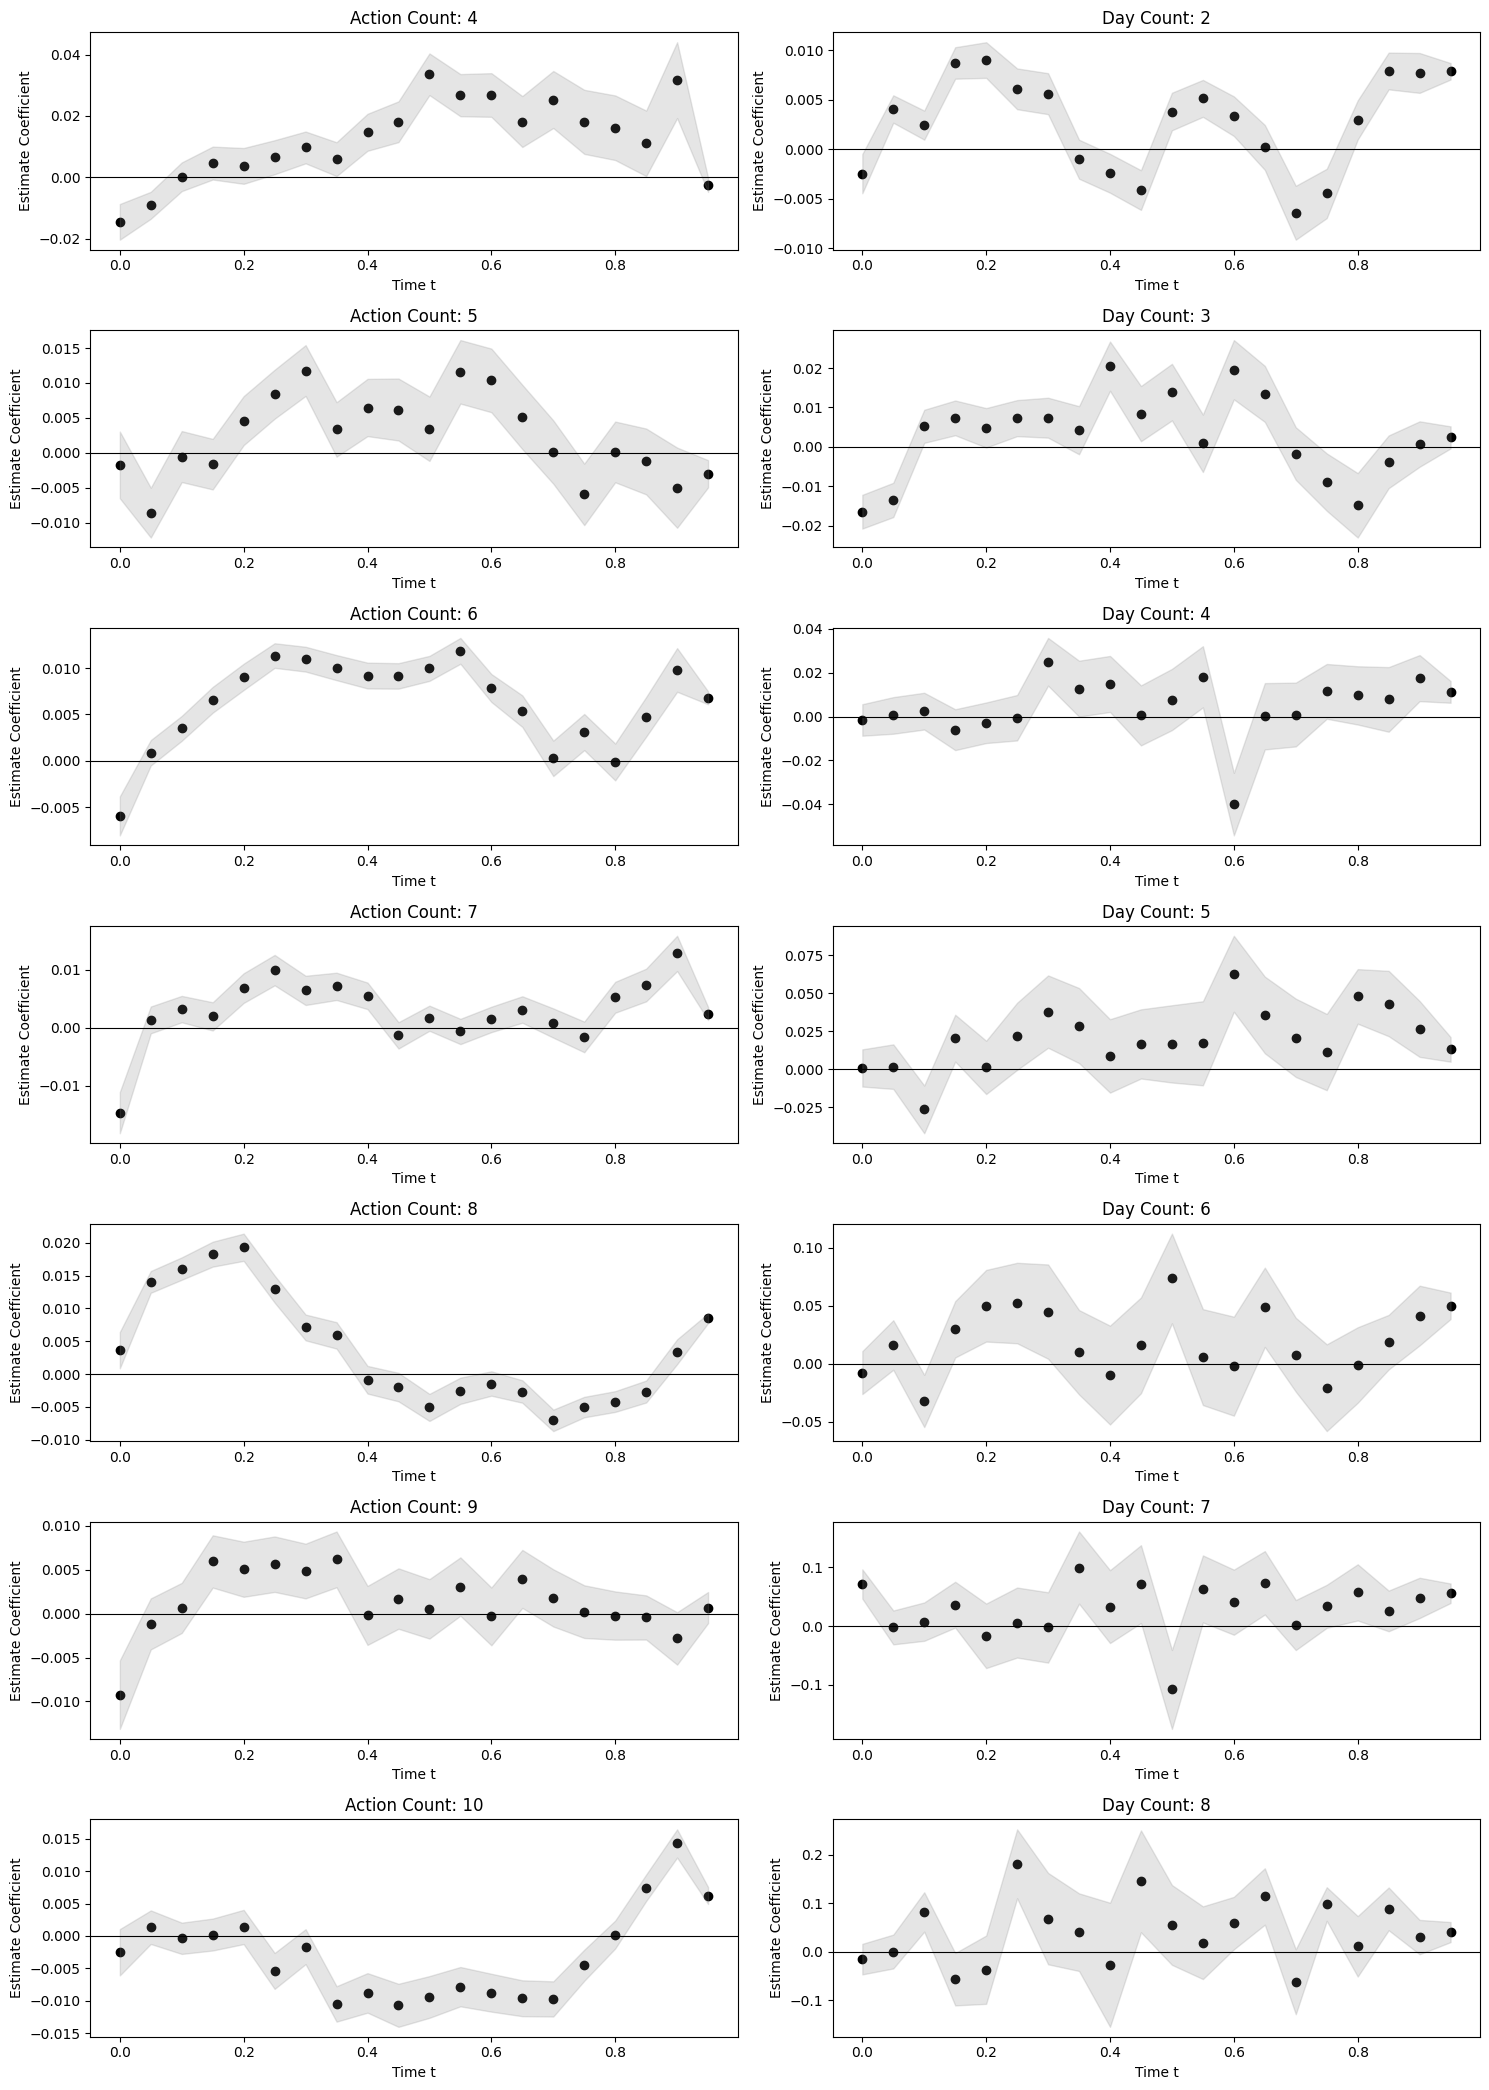

In [11]:
# Plot
plt.figure(figsize=(12, 8))

# Define the number of actions and calculate the number of rows/cols for the subplot grid
cols = 2
rows = 7  # Calculate the needed rows

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))  # Adjust figsize as necessary
# axs = axs.flatten()  # Flatten the axis array for easy iteration if it's 2D

for idx, action_count in enumerate(range(4, 11)):
    # Sample data
    x = np.array(bins)
    y = np.array(action_count_coefficients[idx])
    upper_conf_int = np.array(action_count_upper_conf_ints[idx])
    lower_conf_int = np.array(action_count_lower_conf_ints[idx])

    # Scatter plot
    axs[idx][0].scatter(x, y, color='black')

    # Confidence intervals
    axs[idx][0].fill_between(x, lower_conf_int, upper_conf_int, interpolate=True, color='gray', alpha=0.2)

    # Optional: Titles and labels
    axs[idx][0].set_title(f'Action Count: {action_count}')
    axs[idx][0].set_xlabel('Time t')
    axs[idx][0].set_ylabel('Estimate Coefficient')
    axs[idx][0].axhline(0, color='black', linewidth=0.8)  # Horizontal line at y=0


for idx, day_count in enumerate(range(2, 9)):
    # Sample data
    x = np.array(bins)
    y = np.array(day_count_coefficients[idx])
    upper_conf_int = np.array(day_upper_conf_ints[idx])
    lower_conf_int = np.array(day_lower_conf_ints[idx])

    # Scatter plot
    axs[idx][1].scatter(x, y, color='black')

    # Confidence intervals
    axs[idx][1].fill_between(x, lower_conf_int, upper_conf_int, interpolate=True, color='gray', alpha=0.2)

    # Optional: Titles and labels
    axs[idx][1].set_title(f'Day Count: {day_count}')
    axs[idx][1].set_xlabel('Time t')
    axs[idx][1].set_ylabel('Estimate Coefficient')
    axs[idx][1].axhline(0, color='black', linewidth=0.8)  # Horizontal line at y=0

# Adjust layout
plt.tight_layout()
plt.show()
